In [2]:
import torch 
import torch.nn as nn 
from pprint import pprint
from src.device import select_device 
from src.testtrain import * 
from src.data import fetch_dataset, dataloader
from src.models.mlp import MLP 
from src.models.linear import Linear
from src.regularizers import * 
from src.metrics import * 
import matplotlib.pyplot as plt 
import math, copy

device = select_device()

training_data, test_data = fetch_dataset("MNIST", verbose=False)

train_dataloader, test_dataloader = dataloader(
    training_data, test_data, 
    batch_size=-1
)

Parameter containing:
tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
        [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
        [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
        ...,
        [ 0.0237,  0.0103, -0.0219,  ...,  0.0088, -0.0009,  0.0009],
        [ 0.0144, -0.0336, -0.0346,  ..., -0.0222, -0.0025, -0.0138],
        [-0.0196, -0.0118,  0.0230,  ..., -0.0202,  0.0172,  0.0355]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0092,  0.0277, -0.0110, -0.0335, -0.0282, -0.0120,  0.0338,  0.0150,
         0.0308,  0.0181], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
        [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
        [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
        ...,
        [ 0.0237,  0.0103, -0.0219,  ...,  0.0088, -0.0009,  0.0009],
        [ 0.0144, -

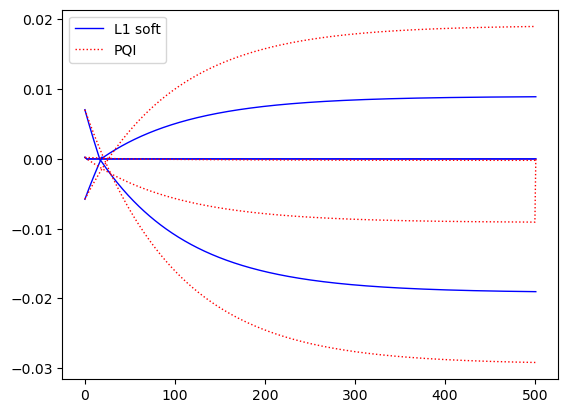

In [3]:
# Comparison of PQI and L1 soft threshold regularization

torch.manual_seed(0)

model = Linear(data_shape = (28, 28), target_size = 10).to(device)
model2 = copy.deepcopy(model) 

for name, param in model.named_parameters(): 
    print(param)
    
p1 = []
p2 = []
cutoff = 0.01

def proximalPQI(model, device, p, q, lmbda, tau): 

    d = 0
    for param in model.parameters(): 
        d += math.prod(param.size())
        
    u = [W.data.detach().clone() for W in model.parameters()]
        
    def objective_function(model): 
        p_norm = torch.norm(torch.stack([torch.norm(param, p) for param in model.parameters()]), p)
        q_norm = torch.norm(torch.stack([torch.norm(param, q) for param in model.parameters()]), q)
        l2_diff = torch.norm(torch.stack([torch.norm([W for W in model.parameters()][i] - u[i]) for i in range(len(u))]))
        output = lmbda * (d ** ((1/q) - (1/p)) * (p_norm/q_norm)) + 1/(2*tau) * l2_diff ** 2
        return  output.to(device)

    with torch.no_grad(): 
        for name, param in model.named_parameters(): 
            torch.manual_seed(2)
            param.copy_(0.01 * torch.randn_like(param))

    # optimizer = LBFGS(model.parameters(), lr=5 * lmbda*tau)
    optimizer = torch.optim.SGD(model.parameters(), lr=lmbda*tau * 0.1, momentum=0.0)

    def closure():
        optimizer.zero_grad()
        loss = objective_function(model)
        loss.backward()
        return loss

    old_value = objective_function(model).item()
    p1.append([W.data.detach().clone() for W in model.parameters()])
    for i in range(500): 
        positives1 = []
        negatives1 = []
        for W in model.parameters(): 
            mask1 = torch.where(W.data >= 0, 1.0, 0.0)
            mask2 = torch.where(W.data <= 0, 1.0, 0.0)
            positives1.append(mask1) 
            negatives1.append(mask2)
            
        optimizer.step(closure)
        new_value = objective_function(model).item()
        
        positives2 = [] 
        negatives2 = [] 
        for W in model.parameters(): 
            mask1 = torch.where(W.data >= 0, 1.0, 0.0)
            mask2 = torch.where(W.data <= 0, 1.0, 0.0)
            positives2.append(mask1) 
            negatives2.append(mask2)
            
        clip_mask = [] 
        for i in range(len(positives1)): 
            clip = positives1[i] * positives2[i] + negatives1[i] * negatives2[i]
            clip_mask.append(clip)
        
        # with torch.no_grad(): 
        #     i = 0
        #     for name, param in model.named_parameters(): 
        #         param.copy_(clip_mask[i] * param)
        #         i += 1 
                
        p1.append([W.data.detach().clone() for W in model.parameters()])
        
        if i % 1 == 0: 
            # print("value", new_value)
            pass 
        # if new_value >= old_value: 
        #     new_value = old_value
        #     print(i)
        #     break
        
    with torch.no_grad(): 
        for name, param in model.named_parameters(): 
            clipped_param = param.clone()
            clipped_param[torch.logical_and(clipped_param >-1e-0 * lmbda*tau, clipped_param < 1e-0 * lmbda*tau)] = 0.0
            param.copy_(clipped_param)
            
    p1.append([W.data.detach().clone() for W in model.parameters()])
        
def proximalL1(model2, device, lmbda, tau): 
    u = [W.data.detach().clone() for W in model.parameters()]
        
    def objective_function(model): 
        one_norm = torch.norm(torch.stack([torch.norm(param, 1) for param in model.parameters()]), 1)
        # print("one_norm", one_norm.item())
        l2_diff = torch.norm(torch.stack([torch.norm([W for W in model.parameters()][i] - u[i]) for i in range(len(u))]))
        # print("l2_diff", l2_diff.item() ** 2)
        output = 1/(2*tau) * l2_diff ** 2 + lmbda * one_norm 
        return output.to(device)

    
    
    with torch.no_grad(): 
        for name, param in model.named_parameters(): 
            torch.manual_seed(2)
            param.copy_(0.01 * torch.randn_like(param))
    
    # optimizer = torch.optim.LBFGS(model.parameters(), lr=lmbda*tau * 0.1, tolerance_change=1e-6)
    optimizer = torch.optim.SGD(model.parameters(), lr=lmbda*tau * 0.1, momentum=0.0)

    def closure():
        optimizer.zero_grad()
        loss = objective_function(model)
        loss.backward()
        return loss

    old_value = objective_function(model).item()
    p2.append([W.data.detach().clone() for W in model.parameters()])
    for i in range(500): 
        positives1 = []
        negatives1 = []
        for W in model.parameters(): 
            mask1 = torch.where(W.data >= 0, 1.0, 0.0)
            mask2 = torch.where(W.data <= 0, 1.0, 0.0)
            positives1.append(mask1) 
            negatives1.append(mask2)
            
        optimizer.step(closure)
        p2.append([W.data.detach().clone() for W in model.parameters()])
        new_value = objective_function(model).item()
        
        positives2 = [] 
        negatives2 = [] 
        for W in model.parameters(): 
            mask1 = torch.where(W.data >= 0, 1.0, 0.0)
            mask2 = torch.where(W.data <= 0, 1.0, 0.0)
            positives2.append(mask1) 
            negatives2.append(mask2)
            
        clip_mask = [] 
        for i in range(len(positives1)): 
            clip = positives1[i] * positives2[i] + negatives1[i] * negatives2[i]
            clip_mask.append(clip)
        
        with torch.no_grad(): 
            i = 0
            for name, param in model.named_parameters(): 
                param.copy_(clip_mask[i] * param)
                i += 1 
        
        if i % 1 == 0: 
            # print("value", new_value)
            pass 
        # if new_value >= old_value: 
        #     new_value = old_value
        #     print(i)
        #     break
        
    with torch.no_grad(): 
        for name, param in model.named_parameters(): 
            clipped_param = param.clone()
            clipped_param[torch.logical_and(clipped_param >-1e-5, clipped_param < 1e-5)] = 0.0
            param.copy_(clipped_param)
    
    p2.append([W.data.detach().clone() for W in model.parameters()])
          

proximalPQI(model, device, 1, 2, math.sqrt(cutoff), math.sqrt(cutoff)) 
proximalL1(model2, device, lmbda=math.sqrt(cutoff), tau=math.sqrt(cutoff))

for name, param in model2.named_parameters(): 
    print(param)
for name, param in model.named_parameters(): 
    print(param)
    
import matplotlib.pyplot as plt

y12 = [param[0][0][0].cpu().numpy() for param in p2] 
y22 = [param[0][0][1].cpu().numpy() for param in p2] 
y32 = [param[0][0][2].cpu().numpy() for param in p2] 
yb2 = [param[1][0].cpu().item() for param in p2] 
plt.plot(range(len(y12)), y12, label="L1 soft", color="b", linewidth=1)
plt.plot(range(len(y22)), y22, color="b", linewidth=1)
plt.plot(range(len(y32)), y32, color="b", linewidth=1)
plt.plot(range(len(yb2)), yb2, color="b", linewidth=1)

y1 = [param[0][0][0].cpu().numpy() for param in p1] 
y2 = [param[0][0][1].cpu().numpy() for param in p1] 
y3 = [param[0][0][2].cpu().numpy() for param in p1] 
yb = [param[1][0].cpu().item() for param in p1] 
plt.plot(range(len(y1)), y1, linestyle=":", label="PQI", color="r", linewidth=1)
plt.plot(range(len(y2)), y2, linestyle=":", color="r", linewidth=1)
plt.plot(range(len(y3)), y3, linestyle=":", color="r", linewidth=1)
plt.plot(range(len(yb)), yb, linestyle=":", color="r", linewidth=1)
plt.legend()
plt.show()

Parameter containing:
tensor([[-0.0342, -0.0169,  0.0137,  ..., -0.0016, -0.0264, -0.0157],
        [-0.0177, -0.0191,  0.0192,  ..., -0.0219,  0.0025, -0.0209],
        [ 0.0177, -0.0163,  0.0332,  ..., -0.0310,  0.0270, -0.0205],
        ...,
        [ 0.0134,  0.0072,  0.0188,  ..., -0.0155, -0.0081,  0.0223],
        [-0.0011, -0.0349, -0.0300,  ..., -0.0130,  0.0063,  0.0226],
        [ 0.0065,  0.0060, -0.0148,  ..., -0.0116,  0.0097,  0.0081]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0270,  0.0148, -0.0232,  0.0119, -0.0229,  0.0125, -0.0220, -0.0334,
        -0.0083,  0.0171], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0242, -0.0069,  0.0037,  ..., -0.0000, -0.0164, -0.0057],
        [-0.0077, -0.0091,  0.0092,  ..., -0.0119,  0.0000, -0.0109],
        [ 0.0077, -0.0063,  0.0232,  ..., -0.0210,  0.0170, -0.0105],
        ...,
        [ 0.0034,  0.0000,  0.0088,  ..., -0.0055, -0.0000,  0.0123],
        [-0.0000, -

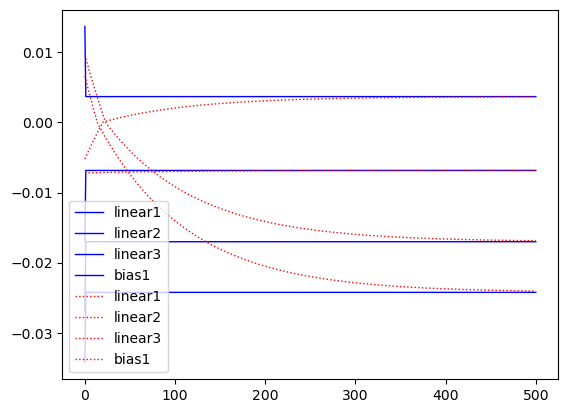

In [5]:
# Comparison of L1 soft thresh vs L1 proximal GD regularization 

model = Linear(data_shape = (28, 28), target_size = 10).to(device)
model2 = copy.deepcopy(model) 

for name, param in model.named_parameters(): 
    print(param)

p1 = []
p2 = []
cutoff = 0.01

def proximalL1(model, device, lmbda, tau): 
    u = [W.data.detach().clone() for W in model.parameters()]
        
    def objective_function(model): 
        one_norm = torch.norm(torch.stack([torch.norm(param, 1) for param in model.parameters()]), 1)
        # print("one_norm", one_norm.item())
        l2_diff = torch.norm(torch.stack([torch.norm([W for W in model.parameters()][i] - u[i]) for i in range(len(u))]))
        # print("l2_diff", l2_diff.item() ** 2)
        output = 1/(2*tau) * l2_diff ** 2 + lmbda * one_norm 
        return output.to(device)

    
    
    with torch.no_grad(): 
        for name, param in model.named_parameters(): 
            param.copy_(0.01 * torch.randn_like(param))
    
    # optimizer = torch.optim.LBFGS(model.parameters(), lr=lmbda*tau * 0.1, tolerance_change=1e-6)
    optimizer = torch.optim.SGD(model.parameters(), lr=lmbda*tau * 0.1, momentum=0.0)

    def closure():
        optimizer.zero_grad()
        loss = objective_function(model)
        loss.backward()
        return loss

    old_value = objective_function(model).item()
    p1.append([W.data.detach().clone() for W in model.parameters()])
    for i in range(500): 
        # positives1 = []
        # negatives1 = []
        # for W in model.parameters(): 
        #     mask1 = torch.where(W.data >= 0, 1.0, 0.0)
        #     mask2 = torch.where(W.data <= 0, 1.0, 0.0)
        #     positives1.append(mask1) 
        #     negatives1.append(mask2)
            
        optimizer.step(closure)
        p1.append([W.data.detach().clone() for W in model.parameters()])
        new_value = objective_function(model).item()
        
        # positives2 = [] 
        # negatives2 = [] 
        # for W in model.parameters(): 
        #     mask1 = torch.where(W.data >= 0, 1.0, 0.0)
        #     mask2 = torch.where(W.data <= 0, 1.0, 0.0)
        #     positives2.append(mask1) 
        #     negatives2.append(mask2)
            
        # clip_mask = [] 
        # for i in range(len(positives1)): 
        #     clip = positives1[i] * positives2[i] + negatives1[i] * negatives2[i]
        #     clip_mask.append(clip)
        
        # with torch.no_grad(): 
        #     i = 0
        #     for name, param in model.named_parameters(): 
        #         param.copy_(clip_mask[i] * param)
        #         i += 1 
        
        if i % 1 == 0: 
            # print("value", new_value)
            pass 
        # if new_value >= old_value: 
        #     new_value = old_value
        #     print(i)
        #     break
        
    with torch.no_grad(): 
        for name, param in model.named_parameters(): 
            clipped_param = param.clone()
            clipped_param[torch.logical_and(clipped_param >-1e-5, clipped_param < 1e-5)] = 0.0
            param.copy_(clipped_param)
            
proximalL1(model, device, lmbda=math.sqrt(cutoff), tau=math.sqrt(cutoff))

p2.append([W.data.detach().clone() for W in model2.parameters()])
with torch.no_grad(): 
    for name, param in model2.named_parameters(): 
        param.copy_(soft_threshold(param, cutoff))
        
for _ in range(500): 
    p2.append([W.data.detach().clone() for W in model2.parameters()])

for name, param in model2.named_parameters(): 
    print(param)
    
for name, param in model.named_parameters(): 
    print(param)
    
import matplotlib.pyplot as plt

y12 = [param[0][0][0].cpu().numpy() for param in p2] 
y22 = [param[0][0][1].cpu().numpy() for param in p2] 
y32 = [param[0][0][2].cpu().numpy() for param in p2] 
yb2 = [param[1][0].cpu().item() for param in p2] 
plt.plot(range(len(y12)), y12, label="linear1", color="b", linewidth=1)
plt.plot(range(len(y22)), y22, label="linear2", color="b", linewidth=1)
plt.plot(range(len(y32)), y32, label="linear3", color="b", linewidth=1)
plt.plot(range(len(yb2)), yb2, label="bias1", color="b", linewidth=1)

y1 = [param[0][0][0].cpu().numpy() for param in p1] 
y2 = [param[0][0][1].cpu().numpy() for param in p1] 
y3 = [param[0][0][2].cpu().numpy() for param in p1] 
yb = [param[1][0].cpu().item() for param in p1] 
plt.plot(range(len(y1)), y1, linestyle=":", label="linear1", color="r", linewidth=1)
plt.plot(range(len(y2)), y2, linestyle=":", label="linear2", color="r", linewidth=1)
plt.plot(range(len(y3)), y3, linestyle=":", label="linear3", color="r", linewidth=1)
plt.plot(range(len(yb)), yb, linestyle=":", label="bias1", color="r", linewidth=1)


plt.legend()
plt.show()

In [6]:
# L1 soft vs L1 proximal 

epochs = 5

# L1 with Proximal LBFGS Optimizer
model = Linear(data_shape = (28, 28, ), target_size = 10).to(device)
model2 = copy.deepcopy(model)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

l1, l2, pqi = 1e-2, 0., 0.
train_losses3, test_losses3 = [], []
test_accuracy3, PQIs3, l0_3 = [], [], []

for t in range(epochs): 
    print(f"Epoch {t}\n-------------------------------")
    
    train_dict = train(train_dataloader, model, loss_fn, optimizer, device, l1=l1, l2=l2, pqi=pqi, t=t, soft_thresh = False)
    test_dict = test(test_dataloader, model, loss_fn, device, l1=l1, l2=l2, pqi=pqi)
    
    train_losses3.append(train_dict["loss"])
    test_losses3.append(test_dict["loss"])
    test_accuracy3.append(test_dict["accuracy"])
    pqi_ = PQI(model, device, 1, 2).item()
    PQIs3.append(1 - pqi_)
    l0_3.append(L0_sparsity(model))
    
    pprint(f"L0 Sparsity : {100 * L0_sparsity(model)}%")
    pprint(f"PQ Sparsity : {1 - pqi_}")

# L1 with Soft Thresholding
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-3, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

train_losses2, test_losses2 = [], []
test_accuracy2, PQIs2, l0_2 = [], [], []


for t in range(epochs): 
    print(f"Epoch {t}\n-------------------------------")
    
    train_dict = train(train_dataloader, model2, loss_fn, optimizer, device, l1=l1, l2=l2, pqi=pqi, t=t, soft_thresh = True)
    test_dict = test(test_dataloader, model2, loss_fn, device, l1=l1, l2=l2, pqi=pqi)
    
    train_losses2.append(train_dict["loss"])
    test_losses2.append(test_dict["loss"])
    test_accuracy2.append(test_dict["accuracy"])
    pqi_ = PQI(model2, device, 1, 2).item()
    PQIs2.append(1 - pqi_)
    l0_2.append(L0_sparsity(model2))
    
    pprint(f"L0 Sparsity : {100 * L0_sparsity(model2)}%")
    pprint(f"PQ Sparsity : {1 - pqi_}")

Epoch 0
-------------------------------
loss: 2.465434  [60000/60000]
Test Error: 
 Accuracy: 7.9%, Avg loss: 2.473238 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.13778936862945557'
Epoch 1
-------------------------------
loss: 2.465434  [60000/60000]
Test Error: 
 Accuracy: 8.1%, Avg loss: 2.458187 

'L0 Sparsity : 0.025477707006369425%'
'PQ Sparsity : 0.13787591457366943'
Epoch 2
-------------------------------
loss: 2.450710  [60000/60000]
Test Error: 
 Accuracy: 8.8%, Avg loss: 2.429924 

'L0 Sparsity : 0.05095541401273885%'
'PQ Sparsity : 0.13807642459869385'
Epoch 3
-------------------------------
loss: 2.423057  [60000/60000]
Test Error: 
 Accuracy: 9.6%, Avg loss: 2.390463 

'L0 Sparsity : 0.03821656050955414%'
'PQ Sparsity : 0.13838130235671997'
Epoch 4
-------------------------------
loss: 2.384440  [60000/60000]
Test Error: 
 Accuracy: 10.8%, Avg loss: 2.341844 

'L0 Sparsity : 0.025477707006369425%'
'PQ Sparsity : 0.13878601789474487'
Epoch 0
-------------------------------
los

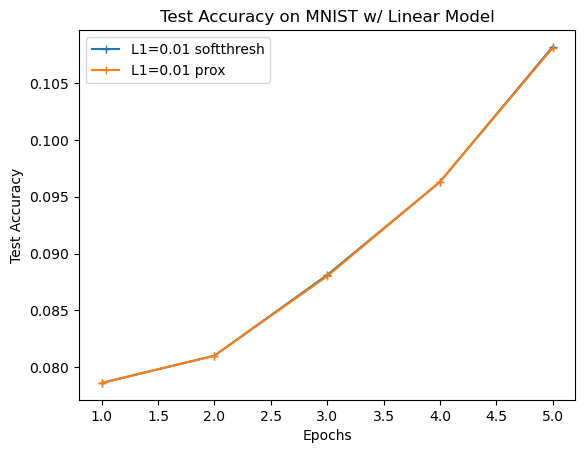

In [7]:
plt.plot(range(1, epochs+1), test_accuracy2, marker="+", label="L1=0.01 softthresh")
plt.plot(range(1, epochs+1), test_accuracy3, marker="+", label="L1=0.01 prox")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy on MNIST w/ Linear Model")
plt.legend()
plt.show() 

In [ ]:
plt.plot(range(1, epochs+1), l0_2, marker="+", label="L1=0.01 softthresh")
plt.plot(range(1, epochs+1), l0_3, marker="+", label="L1=0.01 prox")
plt.xlabel("Epochs")
plt.ylabel("L0 Sparsity")
plt.title("L0 Sparsity on MNIST w/ Linear Model")
plt.legend()
plt.show() 

In [ ]:
plt.plot(range(1, epochs+1), PQIs2, marker="+", label="L1=0.01 softthresh")
plt.plot(range(1, epochs+1), PQIs3, marker="+", label="L1=0.01 prox")
plt.xlabel("Epochs")
plt.ylabel("PQI")
plt.title("PQI Sparsity on MNIST w/ Linear Model")
plt.legend()
plt.show() 